<a href="https://colab.research.google.com/github/SLVmain/PyTorch_start/blob/Les_08/HW_08_final_pytorch_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Generative Adversarial Networks</center></h1>

#Домашнее задание по результатам 8 вебинара.
Как было сказано ранее, GAN обучается воспроизводить реальные данные.
Поэтому Вам предлагается обучить генератор создавать точки, которые будут
лежать на графике функции
$$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
● Сгенерировать настоящие данные
● Изменить архитектуру дискриминатора и генератора
● Без графиков домашку не принимаю


In [2]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

In [3]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


### 1. Загрузка датасета

In [3]:
'''a = torch.randn(10000)
b = np.random.normal( 0, 1, 10)'''

'a = torch.randn(10000)\nb = np.random.normal( 0, 1, 10)'

In [4]:
def func_y_0(x):
  if 0 in x:
    x[x == 0] = 0.00001

  return np.sin(x)/x - x/10

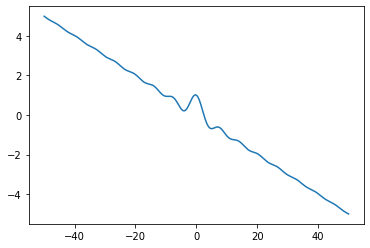

In [5]:
x = np.linspace(-50, 50, 10000)
y = func_y_0(x)
plt.plot(x, y)
plt.show()

In [6]:
def normalize(x):
  res = (x - np.min(x))/(np.max(x) - np.min(x))
  return res

In [7]:
c = np.linspace(-50, 50, 10)
normalize(c)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [8]:
a = [2,5,6]
print(normalize(a))

[0.   0.75 1.  ]


In [9]:
train_data_length = 8192
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = torch.Tensor(normalize(np.linspace(-50, 50, train_data_length)))
train_data[:, 1] = func_y_0(train_data[:, 0])
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [10]:
train_data[:, 0]

tensor([1.0000e-05, 1.2209e-04, 2.4417e-04,  ..., 9.9976e-01, 9.9988e-01,
        1.0000e+00])

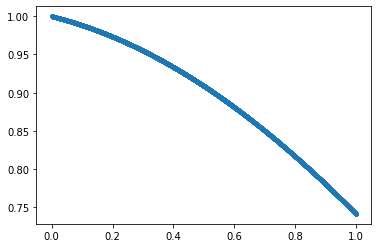

In [12]:
plt.plot(train_data[:, 0], train_data[:, 1], '.')


In [13]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [14]:
dataiter = iter(train_loader)
data_x = dataiter.next()
print(data_x)

[tensor([[0.0805, 0.9909],
        [0.9355, 0.7668],
        [0.7129, 0.8461],
        [0.5821, 0.8863],
        [0.3854, 0.9369],
        [0.9410, 0.7647],
        [0.1187, 0.9858],
        [0.2996, 0.9551],
        [0.9954, 0.7433],
        [0.5908, 0.8838],
        [0.8357, 0.8040],
        [0.1824, 0.9762],
        [0.0415, 0.9956],
        [0.5805, 0.8867],
        [0.8672, 0.7926],
        [0.3672, 0.9410],
        [0.7268, 0.8416],
        [0.6207, 0.8749],
        [0.5670, 0.8906],
        [0.9582, 0.7580],
        [0.4371, 0.9248],
        [0.7545, 0.8323],
        [0.0305, 0.9968],
        [0.0322, 0.9966],
        [0.6964, 0.8515],
        [0.2351, 0.9673],
        [0.1251, 0.9849],
        [0.0297, 0.9969],
        [0.6816, 0.8562],
        [0.3497, 0.9448],
        [0.6433, 0.8681],
        [0.1648, 0.9790]]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])]


### 2. Создание модели

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [16]:
n_epochs = 100  # количество эпох
lr = 0.0001     # шаг обучения

b1 = 0.5        # гиперпараметр для оптимайзера Adam
b2 = 0.999      # гиперпараметр для оптимайзера Adam

#latent_dim = 2    # Размерность случайного вектора, который подается на вход генератору

#sample_interval = 20  # количество итераций для отображения процесса обучения

#batch_size = 32   # размер батча

#f_shape = 2    #  X и Y.


In [17]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)]])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)] # Если мы создаем последовательность слоев - то мы задаем их
                                                    # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation]) # Эта сторчка означает тоже самое что и
                                                       # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(2, 128, normalize=False), # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2),
            nn.ReLU(0.2)
        )
        # 

    def forward(self, z):
        output_ = self.model(z)
        
        return output_


In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, data_in):
        
        validity = self.model(data_in)

        return validity

# 3. Обучение

In [19]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [20]:
d_loss_history = []
g_loss_history = []

процесс обучения, 
график сгенерированных точек выводится на каждой эпохе

[Epoch 99/100] [Batch 252/32] [D loss: 0.691015] [G loss: 0.697839]


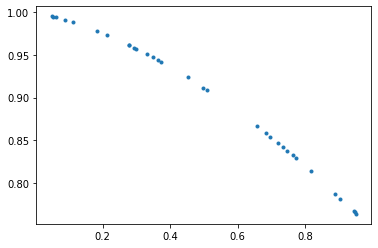

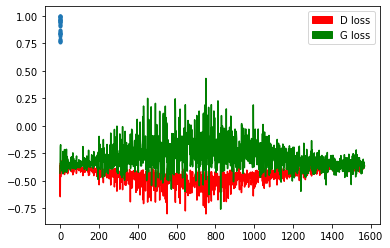

In [24]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')



for epoch in range(n_epochs):
    for i, (real_samples, _) in enumerate(train_loader):

        
##################### Лnnейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        #real_samples_labels = torch.ones((batch_size, 1)).to(device)
        #latent_space_samples = torch.randn((batch_size, 2)).to(device)
        
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_dt = real_samples.type(torch.FloatTensor).to(device)
        #real_samples = real_samples.to(device)

######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, 2))).to(device)
        
        # Генерируем даные Генератором на основе шума
        gen_dt = generator(z)
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_dt)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()


######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_dt)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_dt.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_dt) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_dt), d_loss.item(), g_loss.item()) ) 

                generated_samples = gen_dt.detach().cpu()
                plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")
                

                display.display(plt.gcf())

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
                plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
                plt.legend(handles=[red_patch, green_patch])
                plt.show()

            

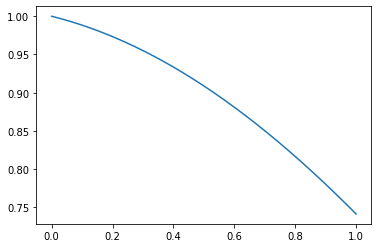

In [26]:
#для сравнения исходный график
plt.plot(train_data[:, 0], train_data[:, 1])

получили данные, очень похожие на исходные

In [20]:
'''for epoch in range(n_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        # Данные для обучения дискриминатора
        # Данные для обучения дискриминатора
        real_samples = real_samples.to(device)
        #единичные лейблы для валидных данных
        real_samples_labels = torch.ones((batch_size, 1)).to(device)
        #создание шума
        latent_space_samples = torch.randn((batch_size, 2)).to(device)
        generated_samples = generator(latent_space_samples).to(device)
        #нулевые лейблы для фейковых данных
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device)
        
        all_samples = torch.cat((real_samples, generated_samples)).to(device)
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        ).to(device)
        
        # Обучение дискриминатора
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = adversarial_loss(
            output_discriminator, all_samples_labels).to(device)
        loss_discriminator.backward()
        optimizer_D.step()

        # Данные для обучения генератора (шум)
        latent_space_samples = torch.randn((batch_size, 2)).to(device)

        # Обучение генератора
        generator.zero_grad()
        generated_samples = generator(latent_space_samples).to(device)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = adversarial_loss(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_G.step()
        # Показать ошибку
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")'''

Epoch: 0 Loss D.: 0.7338923215866089
Epoch: 0 Loss G.: 0.6298244595527649
Epoch: 10 Loss D.: 0.6906738877296448
Epoch: 10 Loss G.: 0.7022876739501953
Epoch: 20 Loss D.: 0.6861050724983215
Epoch: 20 Loss G.: 0.690874457359314
Epoch: 30 Loss D.: 0.6936075091362
Epoch: 30 Loss G.: 0.7203025817871094
Epoch: 40 Loss D.: 0.6790013313293457
Epoch: 40 Loss G.: 0.7384317517280579
Epoch: 50 Loss D.: 0.701734185218811
Epoch: 50 Loss G.: 0.8568160533905029
Epoch: 60 Loss D.: 0.6839019656181335
Epoch: 60 Loss G.: 0.8217995762825012
Epoch: 70 Loss D.: 0.6600666046142578
Epoch: 70 Loss G.: 0.6997248530387878
Epoch: 80 Loss D.: 0.653719425201416
Epoch: 80 Loss G.: 0.7752078771591187
Epoch: 90 Loss D.: 0.6486188173294067
Epoch: 90 Loss G.: 1.0881860256195068


In [30]:
'''# проверим генератор. создадим шум, используем тоже распределение
latent_space_samples = torch.randn(1000, 2).to(device)
#latent_space_samples = torch.linspace(-50,50,100)
generated_samples = generator(latent_space_samples)'''

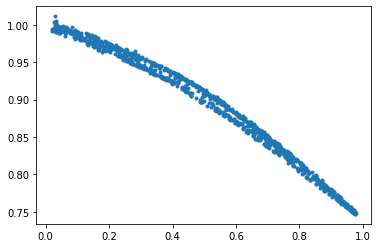

In [31]:
'''generated_samples = generated_samples.detach().cpu()
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")'''